Thank for checking out my Notebook! 

In this notebook #basic Machine learning concept are being used and each and every cells are mentioned with its theory link

This notebook is mostly taken from [BOHAO NING](https://www.kaggle.com/code/doggypiggy/store-sales-getting-started-with-time-series#Evaluation). I just added theory and done more data analysis

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
import seaborn as sns
from plotly import express as px,graph_objects as go
rcParams['figure.figsize'] = (10, 6)

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

Train and Test Data

In [3]:
train = pd.read_csv('train.csv',parse_dates = ['date'], infer_datetime_format = True, dtype = {'store_nbr' : 'category', 'family' : 'category'}, usecols = ['date', 'store_nbr', 'family', 'sales'])
#Pandas Series.dt.to_period() function cast the underlying data of the given Series object to PeriodArray/Index at a particular frequency.
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date','store_nbr','family']).sort_index()
train.head()

sales
date       store_nbr family           
2013-01-01 1         AUTOMOTIVE    0.0
                     BABY CARE     0.0
                     BEAUTY        0.0
                     BEVERAGES     0.0
                     BOOKS         0.0

In [4]:
# Same steps as the train data
test = pd.read_csv('test.csv', parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date','store_nbr','family']).sort_values('id')
test.head()

id  onpromotion
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888            0
                     BABY CARE   3000889            0
                     BEAUTY      3000890            2
                     BEVERAGES   3000891           20
                     BOOKS       3000892            0

# Oil Data

In [5]:

oil = pd.read_csv('oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
print(oil.index[0], oil.index[-1])


2013-01-01 2017-08-31


# Calendar

In [6]:
#Using the full date range
calendar = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
calendar = calendar.join(oil.avg_oil)
#to understand fillna https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
calendar.count()


avg_oil    1695
dtype: int64

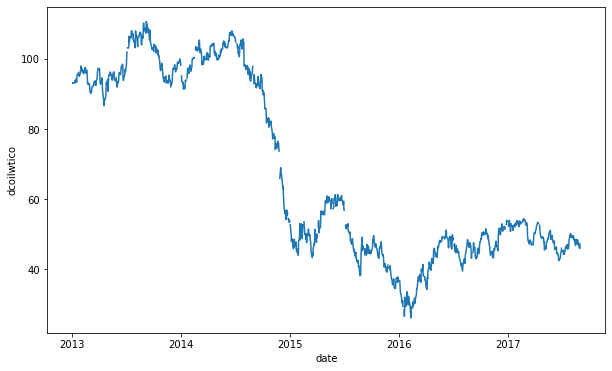

In [7]:
#Plotting oil price
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

Theory of pacf and acf can reference from "https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf"

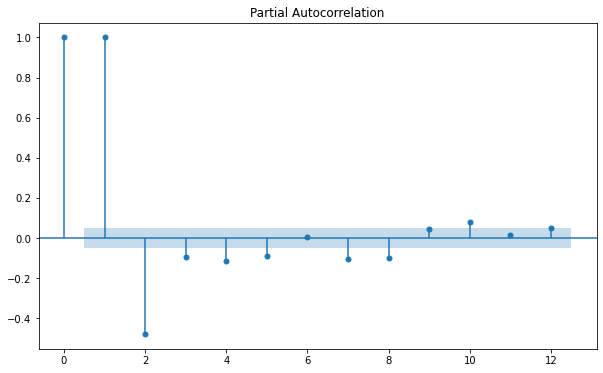

In [8]:
# Plotting the partial autocorrelation function
_ = plot_pacf(calendar.avg_oil, lags = 12)

In [9]:
# Adding lages based on the auto correlation plot (up to 5 will be reasonable)
n_lags = 3
for l in range(1, n_lags+1):
    calendar[f'oil_lags_{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
# calendar.drop('oil_lags1',axis = 1, inplace = True)
calendar.count()

avg_oil       1692
oil_lags_1    1692
oil_lags_2    1692
oil_lags_3    1692
dtype: int64

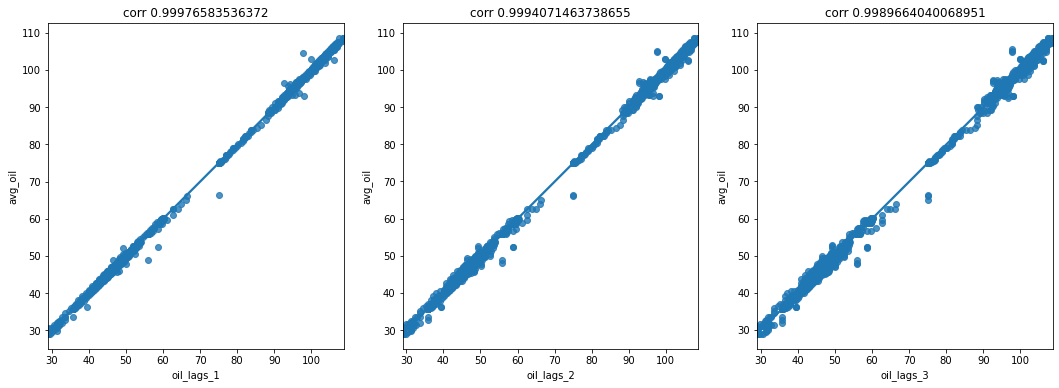

In [10]:
# Checking the correlation plot with different lags

lag1, lag2, lag3 = 'oil_lags_1','oil_lags_2','oil_lags_3'

fig = plt.figure(figsize =(18,6))
plt.subplot(1,3,1)
sns.regplot(x = calendar[lag1], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag1])}')
plt.subplot(1,3,2)
sns.regplot(x = calendar[lag2], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag2])}')
plt.subplot(1,3,3)
sns.regplot(x = calendar[lag3], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag3])}');


# Hoilday Day

In [11]:
Holiday = pd.read_csv('holidays_events.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')
Holiday = Holiday[Holiday.locale == 'National'] #only take National hoilday so there's no false postive
# Removing duplicated hoilday at the same date
Holiday = Holiday.groupby(Holiday.index).first()
Holiday.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [12]:
Holiday.type.value_counts()

Holiday       60
Event         53
Additional    37
Transfer       8
Bridge         5
Work Day       5
Name: type, dtype: int64

# Feature Engineering

In [13]:
# Joining calendar(price) with holiday dataset
calendar =  calendar.join(Holiday)

In [14]:

#Weekly day
calendar['dofw'] = calendar.index.dayofweek
#mark all as work day
calendar['wd'] = 1
# IF it's saturaday or sunday then it's not workday
calendar.loc[calendar.dofw > 4, 'wd'] = 0
#if it's work day eveent then it's a workday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1
#if it's Transfer event then it's not a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0
#if is's bridge event then it's not a workday
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0
# If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0
# If it's holiday and transferred then it's not holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1
#One - hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True)
# One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar = pd.get_dummies(calendar, columns = ['type'])


In [15]:
#Unused columns
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) 
calendar.head()

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0


# Visualization - Sales of Each Product

In [16]:
y = train.unstack(['store_nbr', 'family']).loc['2013':'2017']

y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

                                                 ...                     \
store_nbr                                        ...         9            
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0    0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  374.531   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  400.863   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  310.878   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  447.685   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2013-01-01           0.0          0.0                     0.0    0.000   
2013-01-02         482.0          0.0                     0.0  651.292   
2013-01-03         372.0          0.0                     0.0  509.496   
2013-01-04         324.0          0.0                     0.0  332.672   
2013-01-05         461.0          0.0                     0.0  510.919   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0   0.000  
2013-01-02           83.0     0.0                        0.0  29.214  
2013-01-03           66.0     0.0                        0.0  25.000  
2013-01-04           57.0     0.0                        0.0  11.000  
2013-01-05           84.0     0.0                        0.0  28.361  

[5 rows x 1782 columns]

Point to observe:
- Prepared Foods, bread/Brakery, Dairy,seafood, home applicance, deli, cleaning, beverages and eggs items sales high always 
- Some items sales are low are always ( such as poultry)
- And some product are high in later year( such as books)

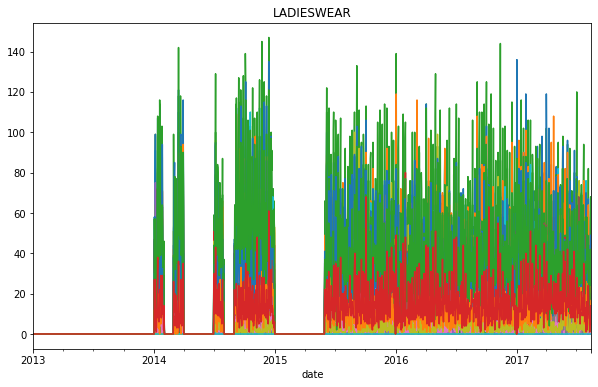

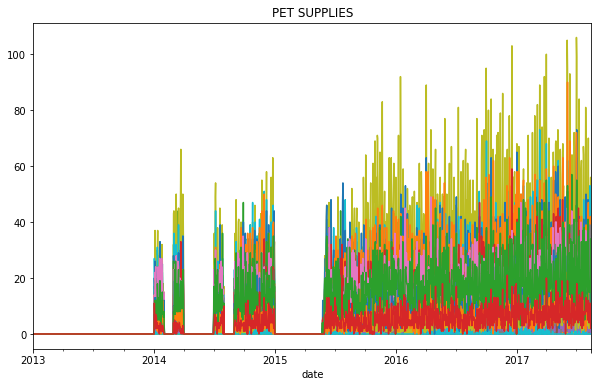

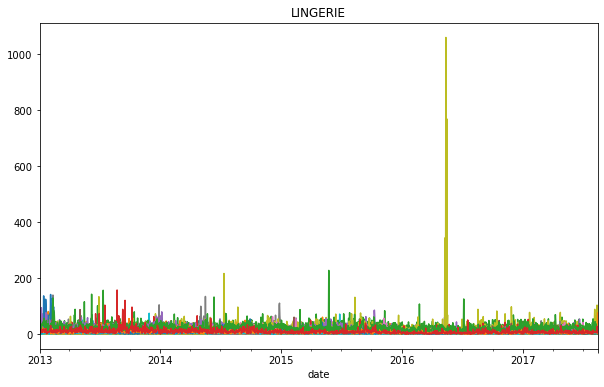

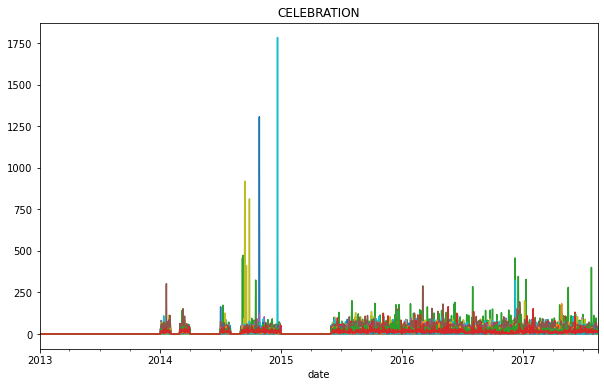

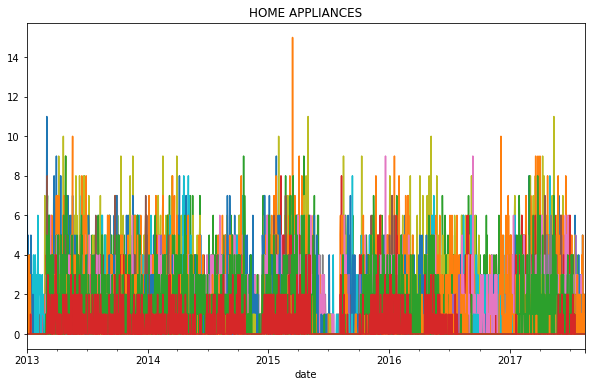

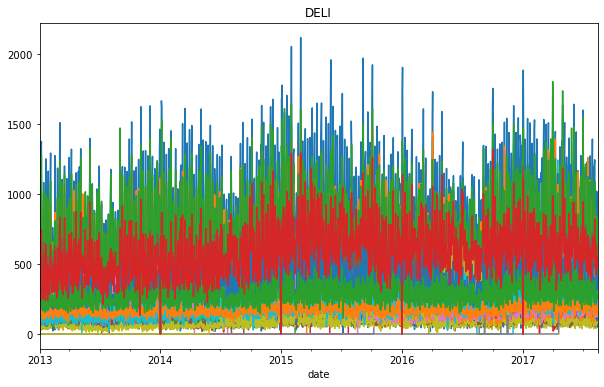

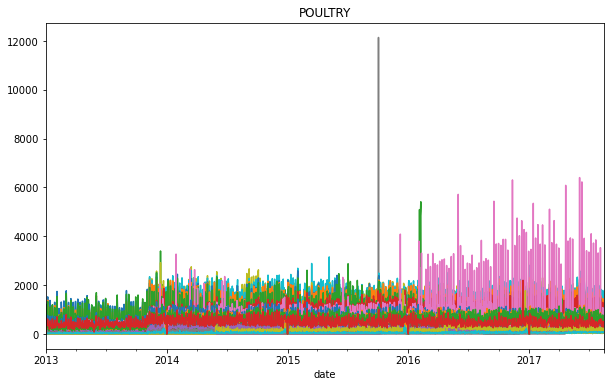

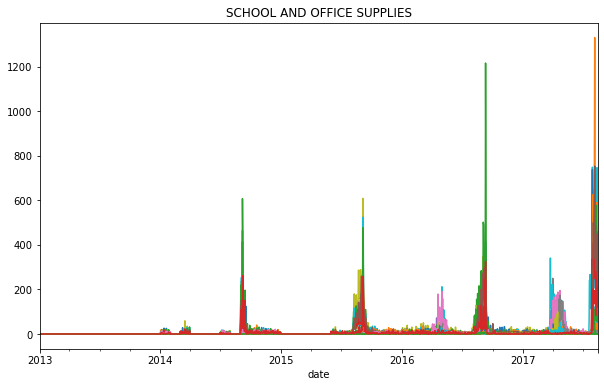

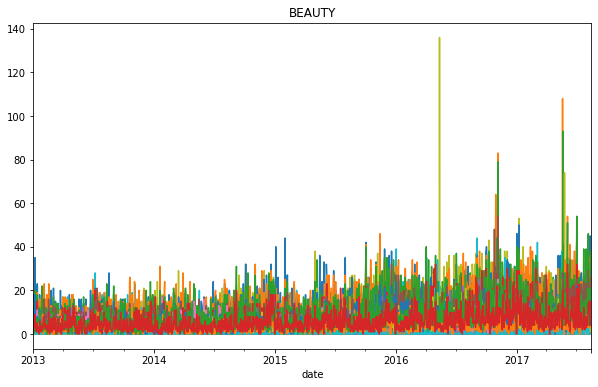

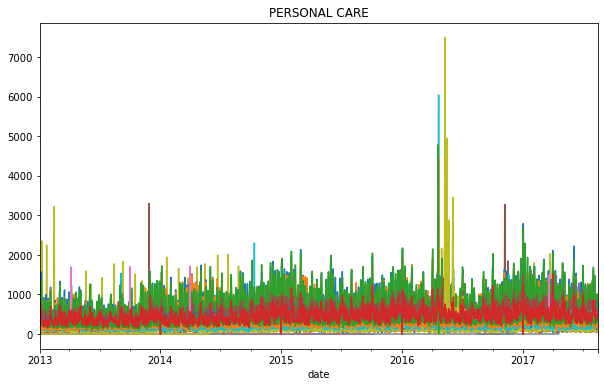

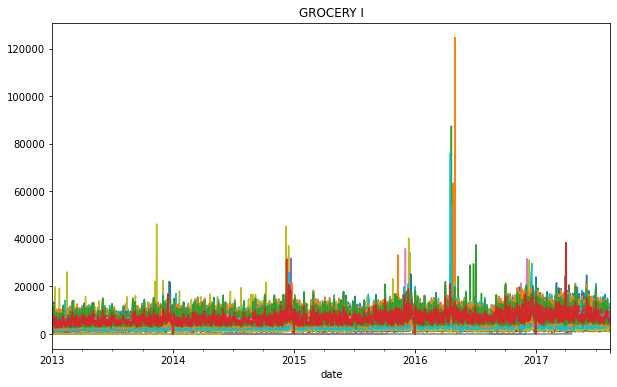

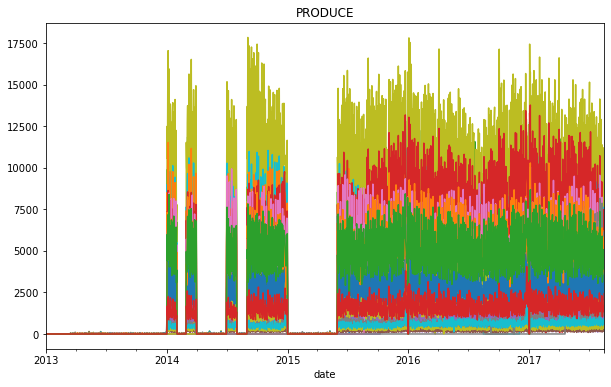

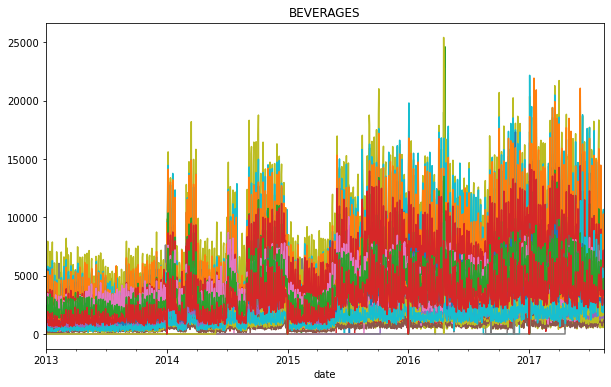

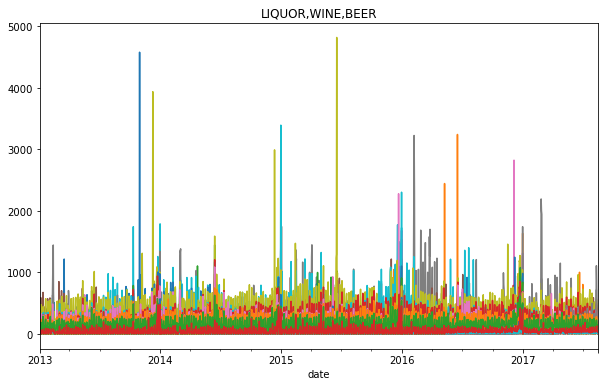

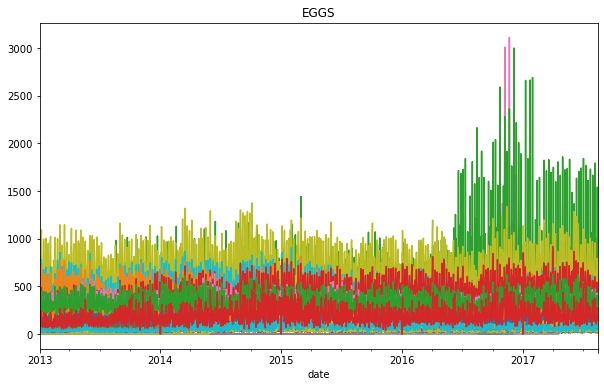

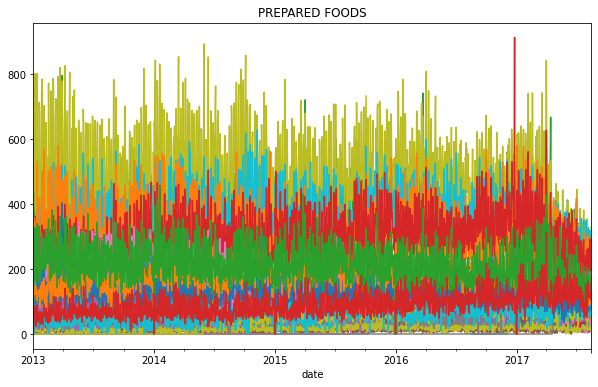

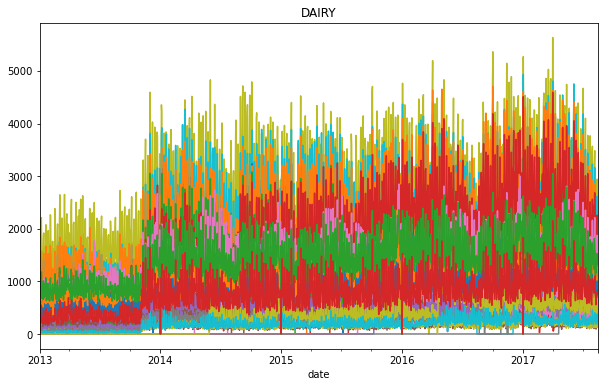

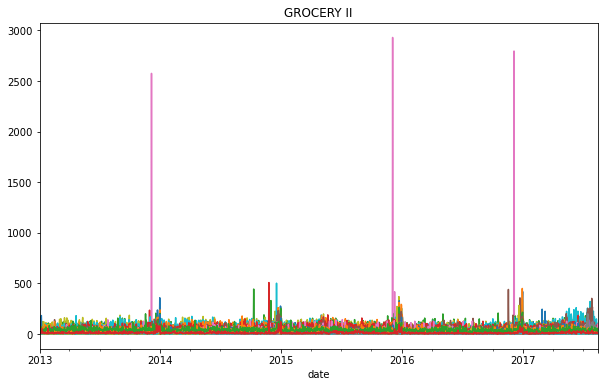

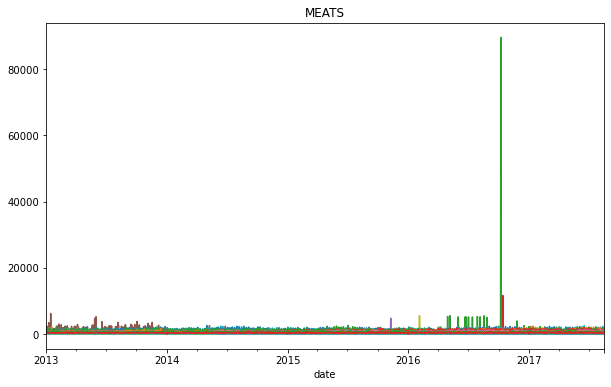

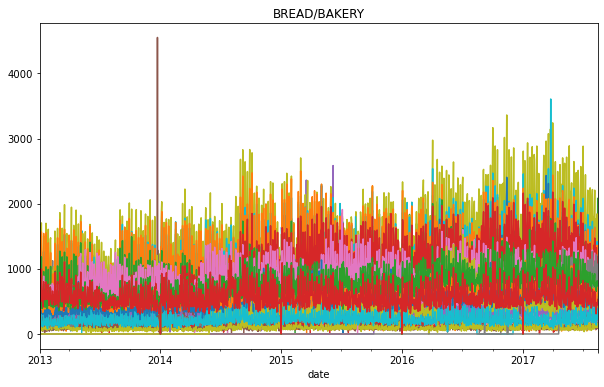

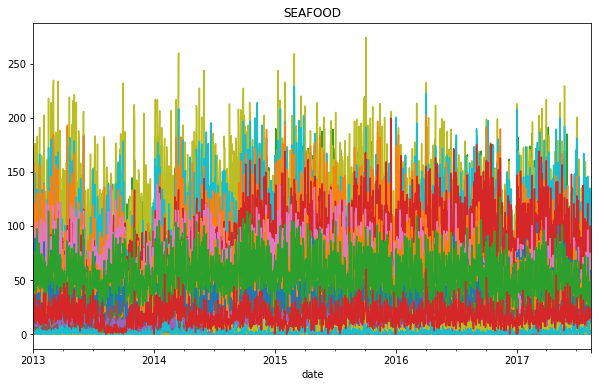

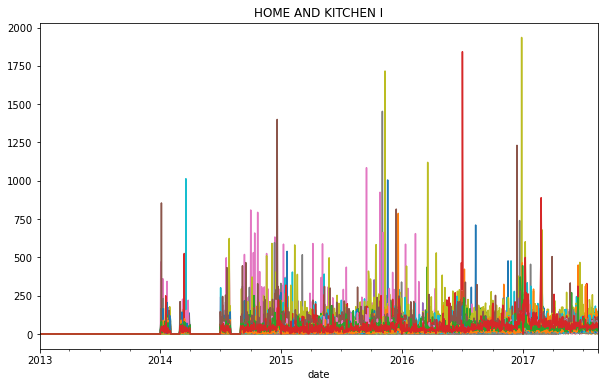

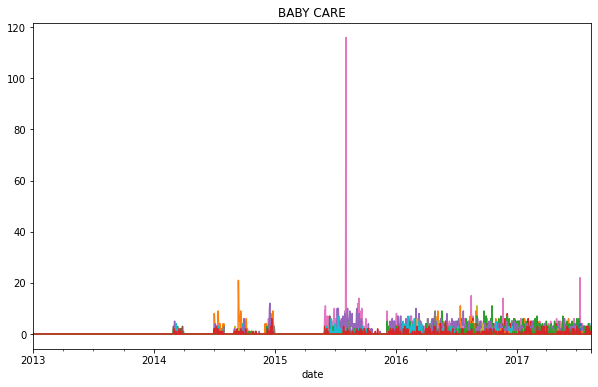

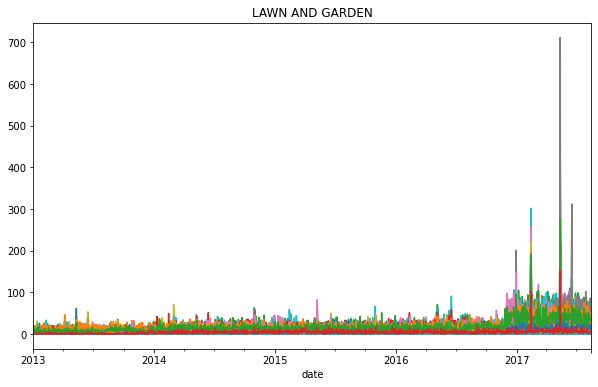

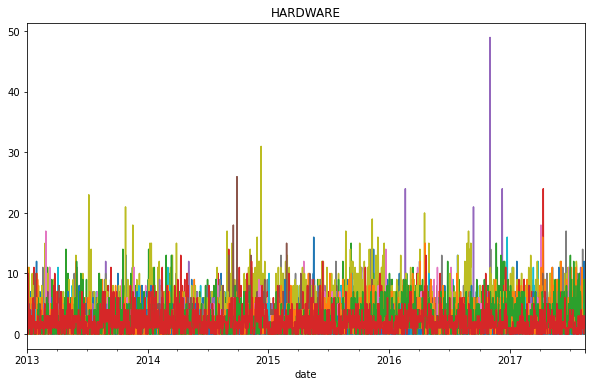

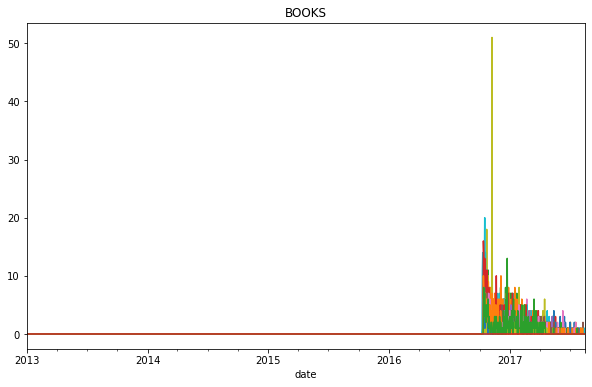

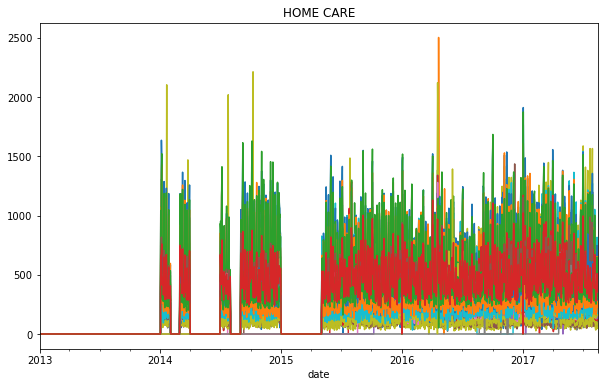

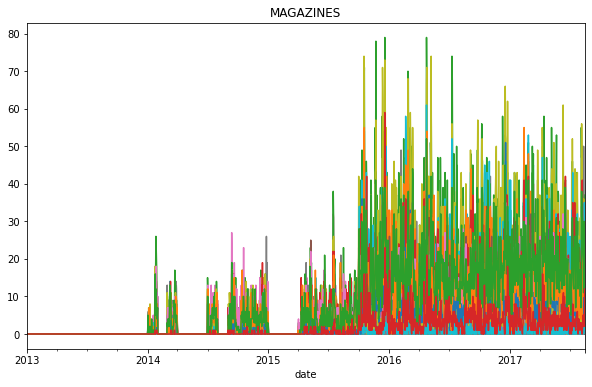

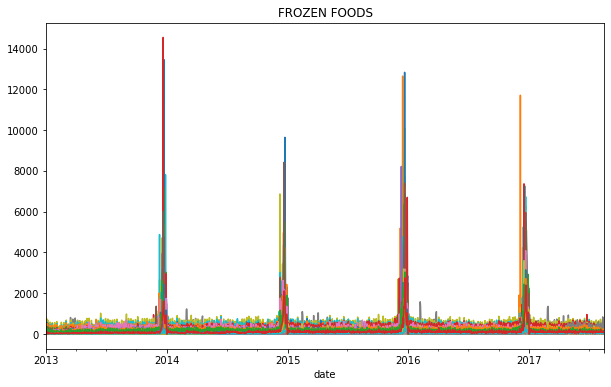

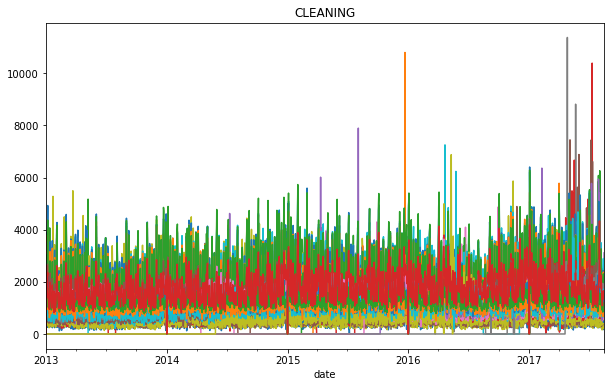

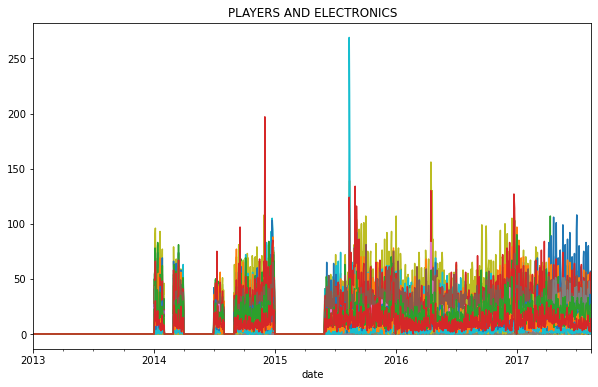

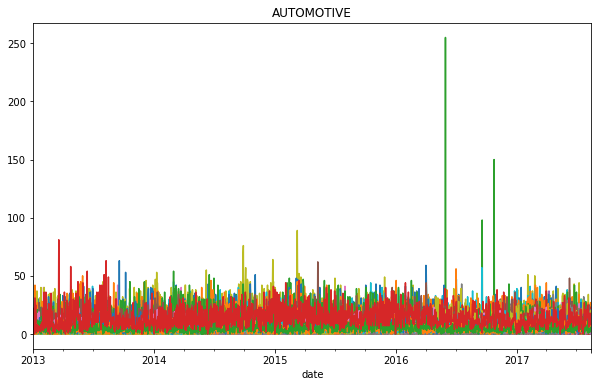

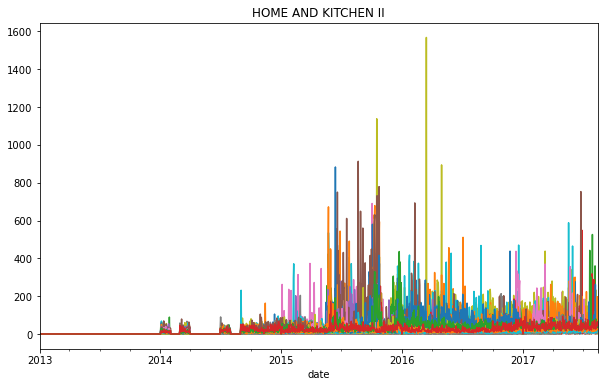

In [17]:
family = {c[2] for c in train.index}
for f in family:
    ax = y.loc(axis =1)['sales', :, f].plot(legend = None)
    ax.set_title(f)

Defining the Training Date

In [18]:
# Start and end of training date (based on plots above)
sdate = '2017-04-30' 
edate = '2017-08-15'

In [19]:
#Adding a feature for school fluctuations
school_season = []
for i,r in calendar.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else:
        school_season.append(0)
calendar['school_season'] = school_season
calendar['school_season'].value_counts()


0    1112
1     580
Name: school_season, dtype: int64

# Deterministic Process
For theory reference below link
 [Kaggle Course](https://www.kaggle.com/learn/time-series)

In [20]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]

y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-04-30        3.0       0.0    0.0     995.0   1.0      139.507   
2017-05-01        0.0       0.0    2.0     825.0   0.0      116.339   
2017-05-02        2.0       0.0    2.0    3179.0   0.0      447.238   
2017-05-03        5.0       0.0    6.0    2479.0   1.0      434.029   
2017-05-04        3.0       0.0    1.0    2454.0   0.0      438.214   

                                                 ...                     \
store_nbr                                        ...         9            
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2017-04-30         2.0    208.0  315.0   60.114  ...       5.0  415.572   
2017-05-01         2.0    227.0  326.0   52.673  ...       5.0  603.395   
2017-05-02        20.0   1061.0  897.0  172.269  ...       0.0  495.275   
2017-05-03        22.0   1117.0  927.0  165.995  ...       4.0  386.662   
2017-05-04        15.0    956.0  755.0  133.780  ...       1.0  601.754   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2017-04-30         678.0         10.0                    16.0  513.866   
2017-05-01         950.0         19.0                    18.0  615.898   
2017-05-02         744.0         10.0                    13.0  346.344   
2017-05-03         513.0          5.0                    11.0  432.579   
2017-05-04         487.0          4.0                    13.0  312.411   

                                                                        
store_nbr                                                               
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                    
2017-04-30        118.588  1762.442                        1.0  21.522  
2017-05-01        175.991  2502.085                        1.0  54.162  
2017-05-02        105.046  2739.654                        5.0  21.362  
2017-05-03         88.384  1442.451                        4.0  16.125  
2017-05-04        104.670  1285.772                        4.0  11.476  

[5 rows x 1782 columns]

In [21]:
# You can refer tutorial time series as Features
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y.index, order = 1, seasonal = False, constant = False, additional_terms = [fourier], drop = True)
x = dp.in_sample()
x = x.join(calendar)
x.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.358571,49.358571,49.358571,...,0,0,1,0,0,0,0,0,0,1
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.154286,49.358571,49.358571,...,0,0,0,0,0,0,1,0,0,1
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,48.870000,49.154286,49.358571,...,0,0,0,0,0,0,0,0,0,1
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.711429,48.870000,49.154286,...,0,0,0,0,0,0,0,0,0,1
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,48.187143,48.711429,48.870000,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# Predicting for the next 16 days
x_test = dp.out_of_sample(steps = 16)
x_test = x_test.join(calendar)
x_test.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,48.648571,48.934286,...,0,0,0,0,0,0,0,0,0,1
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,48.281429,48.648571,...,0,0,0,0,0,0,0,0,0,1
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,47.995714,48.281429,...,1,0,0,0,0,0,0,0,0,1
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,47.852857,47.995714,...,0,1,0,0,0,0,0,0,0,1
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,47.852857,47.852857,...,0,0,1,0,0,0,0,0,0,1


# Linear and SVR model

In [23]:
# Using LinearRegression and SVR to make a generalized line
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error as mae

In [24]:
lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = x_test.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)),'\n')

print('LNR MAE :', mae(y, yfit_lnr))
print('SVR MAE :', mae(y, yfit_svr))
print('Mean MAE :', mae(y, yfit_mean))

LNR RMSLE : 0.39584338358798904
SVR RMSLE : 0.46274117207951615
Mean RMSLE : 0.3846102422210305 

LNR MAE : 53.505642003042844
SVR MAE : 106.34942583041608
Mean MAE : 70.97440163249681


In [25]:
#Concatenating linear regression's prediction with the training data(blending)

ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
# I'm also adding achool lag for its yearly cycle
ymean = ymean.join(school.shift(1), rsuffix = 'lag1')
x = x.loc['2017-05-01':]
# Concatenating linear result
x = x.join(ymean)
x_test = x_test.join(ymean)
y = y.loc['2017-05-01':]

# Final Model

Difference between [Ridge and Lasso](https://www.naukri.com/learning/articles/ridge-regression-vs-lasso-regression/) 

In [26]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [27]:
%%time
model = CustomRegressor(n_jobs=-1, verbose=1)
model.fit(x, y)
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

Fit Progress



Predict Progress



Wall time: 8min 33s


# Evaluation

In [28]:
from sklearn.metrics import mean_squared_log_error
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)

y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

family
AUTOMOTIVE                    0.682456
BABY CARE                     0.485725
BEAUTY                        0.678844
BEVERAGES                     0.429658
BOOKS                         0.345595
BREAD/BAKERY                  0.398289
CELEBRATION                   0.706130
CLEANING                      0.508470
DAIRY                         0.393521
DELI                          0.418994
EGGS                          0.532926
FROZEN FOODS                  0.517150
GROCERY I                     0.407054
GROCERY II                    0.707978
HARDWARE                      0.685809
HOME AND KITCHEN I            0.657512
HOME AND KITCHEN II           0.630601
HOME APPLIANCES               0.589133
HOME CARE                     0.453047
LADIESWEAR                    0.656678
LAWN AND GARDEN               0.636974
LINGERIE                      0.750291
LIQUOR,WINE,BEER              0.688461
MAGAZINES                     0.673514
MEATS                         0.445274
PERSONAL CARE     

In [29]:
y_sub = pd.DataFrame(model.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)
y_sub.head()

Predict Progress


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   4.101210       0.0  4.555177  2262.699439  0.083691   376.819611   
2017-08-17   3.999122       0.0  4.505269  2088.280422  0.000000   353.284558   
2017-08-18   5.929922       0.0  3.980679  2288.157058  0.000000   369.008065   
2017-08-19   4.965905       0.0  3.877032  2209.862598  0.000000   348.557214   
2017-08-20   3.073618       0.0  3.006838  1565.133852  0.000000   250.150492   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   13.125061  735.448669  753.138801  131.533514  ...  3.970148   
2017-08-17   15.382719  663.963996  686.519980  119.971522  ...  3.680161   
2017-08-18   17.416544  706.957555  734.465885  143.791579  ...  3.781211   
2017-08-19   10.735072  615.051010  705.011593  125.079938  ...  3.651006   
2017-08-20    6.669106  438.649582  506.903841   91.668356  ...  4.110892   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  337.146317    410.780229     6.009618                7.351360   
2017-08-17  438.397928    416.272245     5.683439                7.931154   
2017-08-18  323.688594    388.093422     5.482943                7.141197   
2017-08-19  365.193874    500.755977     7.581788               10.207814   
2017-08-20  392.215451    525.389308     7.918698               10.760367   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
2017-08-16  373.582460     112.954027  1344.949804                 115.604444   
2017-08-17  361.465323     111.357439  1328.097938                 135.637111   
2017-08-18  448.588656     111.370281  1342.269305                 131.171111   
2017-08-19  460.265812     132.011883  1602.542940                 143.261556   
2017-08-20  502.381822     132.721472  1779.131783                 171.942667   

                       
store_nbr              
family        SEAFOOD  
2017-08-16  14.919700  
2017-08-17  14.169195  
2017-08-18  14.172230  
2017-08-19  20.028306  
2017-08-20  20.864950  

[5 rows x 1782 columns]

In [30]:
y_sub = y_sub.stack(['store_nbr', 'family'])
y_sub.head()

sales
           store_nbr family                 
2017-08-16 1         AUTOMOTIVE     4.101210
                     BABY CARE      0.000000
                     BEAUTY         4.555177
                     BEVERAGES   2262.699439
                     BOOKS          0.083691

# Submission

In [32]:
sub = pd.read_csv('sample_submission.csv')
sub['sales'] = y_sub.values
sub.head()
sub.to_csv('submission.csv', index = False)

Don't forget to comment your feedback :)